# Aim 2 PCA and K-Means Clustering

In [1]:
# import packages

import math
import numpy as np
import pandas as pd
import scipy as sp
from scipy import cluster, spatial
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing, decomposition, cluster, ensemble, model_selection, metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors

/Applications/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Read in and clean up dataframe

In [2]:
data = pd.read_csv('data2.csv')
cancerfreq = pd.read_csv('cancerfreq.csv')
print(data.shape)
for column in data.columns:
    data = data[pd.isnull(data[column]) == False]
data = data.drop(['Unnamed: 0'],axis = 1)
cancerfreq = cancerfreq.drop(['Unnamed: 0'],axis = 1)
#indices = np.array(['A to T', 'A to G', 'A to C', 'T to A', 'T to G', 'T to C', 'G to A', 'G to T', 'G to C', 'C to A', 'C to T', 'C to G', 'NP neutral to P neutral', 'NP neutral to P acidic', 'NP neutral to P basic', 'P neutral to NP neutral', 'P neutral to P acidic', 'P neutral to P basic', 'P acidic to NP neutral', 'P acidic to P neutral', 'P acidic to P basic', 'P basic to NP neutral', 'P basic to P neutral', 'P basic to P acidic', 'Pathogenic']) 
#cancerfreq.set_index(indices)

(251544, 14)


### Create categorical variables

In [3]:
basepair = np.zeros((data.shape[0], 12))
aminoacid = np.zeros((data.shape[0], 12))
for i, amino_acid in enumerate(data['Amino Acid Classification']):
    aminoacid[i][amino_acid-1] = 1
for i, base_pair in enumerate(data['Base Pair Substitutions']):
    basepair[i][base_pair-1] = 1
basepair = pd.DataFrame(data=basepair, columns = ['A to T', 'A to G', 'A to C', 'T to A', 'T to G', 'T to C', 'G to A', 'G to T', 'G to C', 'C to A', 'C to T', 'C to G'])
aminoacid = pd.DataFrame(data=aminoacid, columns = ['NP neutral to P neutral', 'NP neutral to P acidic', 'NP neutral to P basic', 'P neutral to NP neutral', 'P neutral to P acidic', 'P neutral to P basic', 'P acidic to NP neutral', 'P acidic to P neutral', 'P acidic to P basic', 'P basic to NP neutral', 'P basic to P neutral', 'P basic to P acidic'])

In [20]:
#data1 = data
data1 = data.join(basepair)
#data1 = data1.join(aminoacid)
#data1.head(3).to_csv('sample.csv')

### Create numerical dataframe for standardization and PCA

In [8]:
data1.columns
num_data = data1.drop(['Amino_acid_substitution', 'Cancer Classification', 'Pathogenicity Classification', 'Length-normalized variant freq', 'Ensembl_gene_ID','PON-P2_error','Protein length','Base Pair Substitutions','Variant freq'], axis = 1)
for column in num_data.columns:
    num_data = num_data[pd.isnull(num_data[column]) == False]
num_data_std = sklearn.preprocessing.scale(num_data)
num_data_std = pd.DataFrame(data = num_data_std, columns = num_data.columns, index =  num_data.index)

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


### Run and plot PCA

In [26]:
pca3 = sklearn.decomposition.PCA(n_components=3)
nd = pca3.fit_transform(num_data_std) 
nd_df = pd.DataFrame(data = nd, columns = ['PC1', 'PC2', 'PC3'])
nd_df['Cluster'] = data['Cancer Classification']
pca3.explained_variance_ratio_

array([ 0.07832885,  0.07411111,  0.06935196])

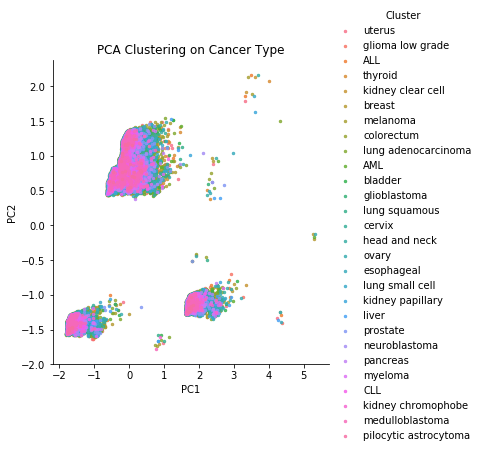

In [27]:
#2.2.3
sb.lmplot( x="PC1", y="PC2", data=nd_df, fit_reg=False, hue='Cluster', legend=True, scatter_kws={"s": 6})
plt.title('PCA Clustering on Cancer Type')
plt.show()

### Visualization of base pair substitutions in breast

In [262]:
breast_nd_df = nd_df.loc[(nd_df['Cluster'] == 'breast')]
breast_nd_df['Cluster'] = data['Base Pair Substitutions']
breast_nd_df.head(10)
sb.lmplot( x="PC1", y="PC2", data=breast_nd_df, fit_reg=False, hue='Cluster', legend=True, scatter_kws={"s": 6})
plt.show()

/Applications/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

### Attempt at 3D visualization

In [16]:
# 3D plot
#fig = plt.figure(figsize = (10,10),dpi=80)
#ax = plt.axes(projection='3d')
#nd_df['Cluster'] = data['Cancer  Substitutions']
#ax.scatter(nd_df['PC1'], nd_df['PC2'], nd_df['PC3'], cmap= viridis(nd_df['Cluster']), s=60)
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.zlabel('PC3')
#ax.view_init(30, 185)
#plt.show()

### K-means clustering for cancer type

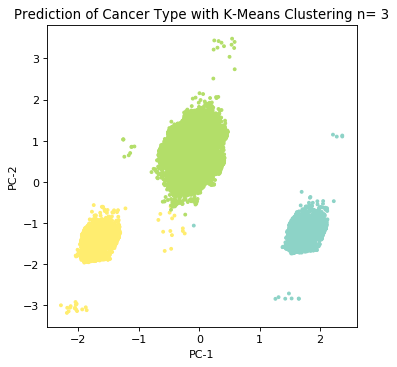

In [264]:
#cluster using kmeans
cluster_n = 3
kmeans = KMeans(n_clusters=cluster_n)  
kmeans.fit(nd)  

#plot the data for Kmeans
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(nd[:,0],nd[:,1], c=kmeans.labels_, cmap= plt.cm.Set3, s=6)
plt.title('Prediction of Cancer Type with K-Means Clustering n= 3')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

In [236]:
# adjust this to include different cancer types 
cluster_n = 28
kmeans = KMeans(n_clusters=cluster_n)  
kmeans.fit(nd)  
metrics.homogeneity_score(nd_df['Cluster'], kmeans.labels_)

TypeError: unorderable types: str() > float()

### K-means clustering for base pair substitutions

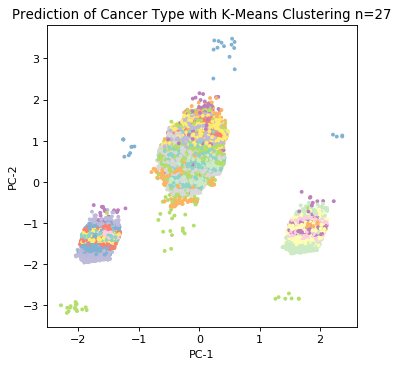

In [263]:
#cluster using kmeans
cluster_n = 27
kmeans = KMeans(n_clusters=cluster_n)  
kmeans.fit(nd)  

#plot the data for Kmeans
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(nd[:,0],nd[:,1], c=kmeans.labels_, cmap= plt.cm.Set3, s=6)
plt.title('Prediction of Cancer Type with K-Means Clustering n=27')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

In [265]:
homogeneity = []
completeness = []
for n in range(12, 32):
    kmeans = KMeans(n_clusters= n)  
    kmeans.fit(nd) 
    nd_df['Cluster'] = data['Base Pair Substitutions']
    homogeneity.append(metrics.homogeneity_score(nd_df['Cluster'], kmeans.labels_))
    completeness.append(metrics.completeness_score(nd_df['Cluster'], kmeans.labels_))
# 27 seems to be the best 

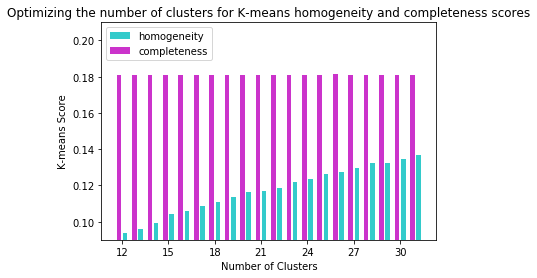

In [283]:
x = range(12, 32)
x1 = [a + 0.2 for a in x]
x2 = [a - 0.2 for a in x]
plt.bar(x1, height = homogeneity, width = 0.3, alpha = 0.8, color = 'c', label = 'homogeneity')
plt.bar(x2, height = completeness, width = 0.3, alpha = 0.8, color= 'm', label = 'completeness')
plt.legend (loc = 'upper left')
plt.axis(ymin = 0.09, ymax = 0.21)
plt.xticks(np.arange(12, 32, step=3))
plt.ylabel('K-means Score')
plt.xlabel('Number of Clusters')
plt.title('Optimizing the number of clusters for K-means homogeneity and completeness scores')
plt.show()

### TSNE

In [217]:
tsne2 = TSNE(n_components=2, perplexity = 200).fit_transform(num_data_std.tail(20000))
tsne2.shape

(20000, 2)

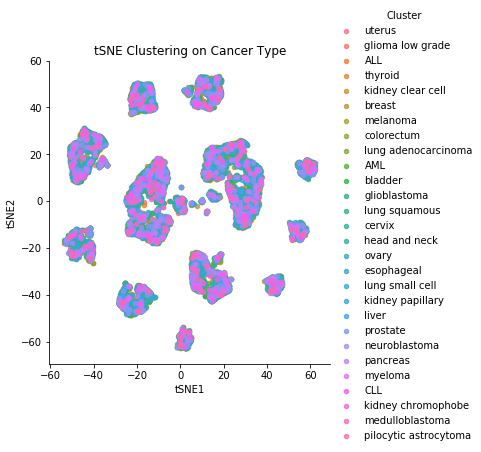

In [218]:
tsne = pd.DataFrame(data = tsne2, columns = ['tSNE1', 'tSNE2'])
tsne['Cluster'] = data['Cancer Classification']
sb.lmplot( x="tSNE1", y="tSNE2", data=tsne, fit_reg=False, hue='Cluster', legend=True, scatter_kws={"s": 20})
plt.title('tSNE Clustering on Cancer Type')
plt.show()

### K Nearest Neighbors

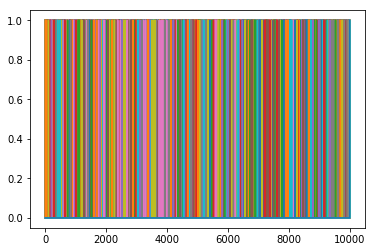

In [210]:
from sklearn.neighbors import kneighbors_graph
tsne = pd.DataFrame(data = , columns = ['tSNE1', 'tSNE2'])
A = kneighbors_graph(, 2, mode='connectivity', include_self=True)
A1 = A.toarray()
plt.plot(A1)
plt.show()

### Statistics